In [3]:
# Set up environment

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import scipy as sp
from itertools import combinations
import ciftools_FA as ct
import statsmodels.api as sm
from statsmodels.formula.api import ols
import subprocess as sp
import scikit_posthocs as ph
import pingouin as pg
import networkx as nx
from joblib import Parallel, delayed

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/home/fralberti/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
''' INPUT VARIABLES '''

# directory containing subdirectories named fter subject IDs that contain the timeseries and surface files
root_dir = "/home/fralberti/Data/HCP_1200"
# directory where all intermediate files and the final output will be saved
output_dir = "/home/fralberti/Documents/BlackBox/Prj-Network_variability/Analyses-bis"
# list of IDs of subjects to include in the Analysis
f = open(f'{root_dir}/subj_IDs_338.txt', 'r')
subj_id = np.array(f.read().splitlines(), dtype='int32')
del f
nj = -2

g = 0
SD = f'SD{g+1}'
G = f'G{g+1}'

group = '338'

lbl_N = 400
nw_N = 7

agg = 'median'
disp = "dist"
disp_col = 'tot'


networks = nib.load(f'/home/fralberti/Data/Shaefer2018_HCP/Schaefer2018_{lbl_N}Parcels_{nw_N}Networks_order.dlabel.nii') #
NW_tbl = ct.agg_networks(networks, networks, func=agg, by_hemisphere=False, label_tbl=True)[1]
nw_name = NW_tbl.groupby('name').agg(agg).sort_values('network').index.to_list()[1:]


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/home/fralberti/anaconda3/lib/python3.9/site-packages/ciftools_FA/ciftools_FA.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_tbl.name[1:] = labels_tbl[1:].name.apply(lambda x: x.split('_')[2])


In [ ]:
%%time

''' Extract vertex-parcel-network GCCA (individual and group median) from dscalar.nii'''

grad_NW = []
grad_lbl = []
grad_vtx = []

for subj in subj_id:
    grad = nib.load(f'{root_dir}/{subj}/Analysis/{subj}.GCCA_525.32k_fs_LR.dscalar.nii')
    NW_df, NW_tbl = ct.agg_networks(grad, networks, func=agg, by_hemisphere=False, label_tbl=True)
    NW_df.iloc[0, :] = 0
    NW_tbl.iloc[0, :] = 0
    lbl_df = ct.agg_labels(grad, networks, func=agg)    
    
    # Append subject's vertex, label, and network-level gradients to group list (for SD)
    grad_NW.append(NW_df.T.values)
    grad_lbl.append(lbl_df.T.values)
    grad_vtx.append(grad.get_fdata())
    
    # Save median individual median gradient of parcels and networks
    np.save(f'{output_dir}/{subj}.gcca.{nw_N}NWs', NW_df) 
    np.save(f'{output_dir}/{subj}.gcca.{lbl_N}Parc', lbl_df)

    

# Save parcels' and networks' median gradient of all subjects
np.save(f'{output_dir}/{group}.gcca.{nw_N}NWs', np.array(grad_NW)) 
np.save(f'{output_dir}/{group}.gcca.{lbl_N}Parc', np.array(grad_lbl))
np.save(f'{output_dir}/{group}.gcca.32k_fs_LR', np.array(grad_vtx)) 


In [ ]:
%%time
from joblib import Parallel, delayed

def fun(subj, root_dir, output_dir, nw_N, lbl_N):
    grad = nib.load(f'{root_dir}/{subj}/Analysis/{subj}.GCCA_525.32k_fs_LR.dscalar.nii')
    NW_df, NW_tbl = ct.agg_networks(grad, networks, func=agg, by_hemisphere=False, label_tbl=True)
    NW_df.iloc[0, :] = 0
    NW_tbl.iloc[0, :] = 0
    lbl_df = ct.agg_labels(grad, networks, func=agg)    
    
    # Append subject's vertex, label, and network-level gradients to group list (for SD)
    grad_NW = NW_df.T.values
    grad_lbl = lbl_df.T.values
    grad_vtx = np.asarray(grad.get_fdata())
    
    # Save median individual median gradient of parcels and networks
    np.save(f'{output_dir}/{subj}.gcca.{nw_N}NWs', NW_df) 
    np.save(f'{output_dir}/{subj}.gcca.{lbl_N}Parc', lbl_df)
    
    return grad_NW, grad_lbl, grad_vtx
    
r = Parallel(n_jobs=nj)(delayed(fun)(subj, root_dir, output_dir, nw_N, lbl_N) for subj in subj_id)
# unpack output
grad_NW, grad_lbl, grad_vtx = zip(*r)

# Save parcels' and networks' median gradient of all subjects
np.save(f'{output_dir}/{group}.gcca.{nw_N}NWs', np.array(grad_NW)) 
np.save(f'{output_dir}/{group}.gcca.{lbl_N}Parc', np.array(grad_lbl))
np.save(f'{output_dir}/{group}.gcca.32k_fs_LR', np.array(grad_vtx)) 

In [ ]:
''' Calculate dispersion of connectivity in 3D gradient space'''

def gcca_determinant(gcca):
    var = np.array([np.diag(np.cov(gcca[:,:,i].T, bias=True)) for i in range(gcca.shape[2])], ndmin = 2).T
    det = np.array([np.linalg.det(np.cov(gcca[:,:,i].T, bias=True)) for i in range(gcca.shape[2])], ndmin = 2)
    return np.vstack([det, var])
        

def gcca_distance(gcca):
    centroids = gcca.mean(axis=0)
    squares = np.square(gcca - centroids)
    sum_squares = squares[:, :2, :].sum(axis=1)
    distance = np.sqrt(sum_squares)
    avg_distance2 = np.square(distance).sum(axis=0) / distance.shape[0]
    avg_components2 = squares.sum(axis=0) / squares.shape[0]
    return np.vstack([avg_distance2, avg_components2])
    

gcca_nw = np.load(f'{output_dir}/{group}.gcca.{nw_N}NWs.npy')
gcca_parc = np.load(f'{output_dir}/{group}.gcca.{lbl_N}Parc.npy')
gcca_vtx = np.load(f'{output_dir}/{group}.gcca.32k_fs_LR.npy')

    # INTERQUARTILE RANGE of gradient value and SD of vertexes, parcels, and networks
if disp == "IQR":
    dispersion_nw = stats.iqr(np.array(gcca_nw), axis=0, rng=(25, 75), scale='normal')
    dispersion_nw = np.vstack([dispersion_nw.sum(axis=0), dispersion_nw])
    dispersion_parc = stats.iqr(np.array(gcca_parc), axis=0, rng=(25, 75), scale='normal')
    dispersion_parc = np.vstack([dispersion_parc.sum(axis=0), dispersion_parc])
    dispersion_vtx = stats.iqr(np.array(gcca_vtx), axis=0, rng=(25, 75), scale='normal')
    dispersion_vtx = np.vstack([dispersion_vtx.sum(axis=0), dispersion_vtx])

    np.save(f'{output_dir}/{group}.gcca_IQR.{nw_N}NWs', dispersion_nw)
    np.save(f'{output_dir}/{group}.gcca_IQR.{lbl_N}Parc', dispersion_parc)
    np.save(f'{output_dir}/{group}.gcca_IQR.32k_fs_LR', dispersion_vtx)

# DETERMINANT of the variance-covariance matrix
elif disp == "det":
    dispersion_nw = gcca_determinant(gcca_nw)
    dispersion_parc = gcca_determinant(gcca_parc)
    dispersion_vtx = gcca_determinant(gcca_vtx)

    np.save(f'{output_dir}/{group}.gcca_det.{nw_N}NWs', dispersion_nw)
    np.save(f'{output_dir}/{group}.gcca_det.{lbl_N}Parc', dispersion_parc)
    np.save(f'{output_dir}/{group}.gcca_det.32k_fs_LR', dispersion_vtx)    

# AVVERAGE SQUARED DISTANCE from group centroid
elif disp == "dist":
    dispersion_nw = gcca_distance(gcca_nw)
    dispersion_parc = gcca_distance(gcca_parc)
    dispersion_vtx = gcca_distance(gcca_vtx)

    np.save(f'{output_dir}/{group}.gcca_dist.{nw_N}NWs', dispersion_nw)
    np.save(f'{output_dir}/{group}.gcca_dist.{lbl_N}Parc', dispersion_parc)
    np.save(f'{output_dir}/{group}.gcca_dist.32k_fs_LR', dispersion_vtx)


In [84]:
''' Save dscalar files'''

# Load gcca data
gcca_nw = np.load(f'{output_dir}/{group}.gcca.{nw_N}NWs.npy')
gcca_parc = np.load(f'{output_dir}/{group}.gcca.{lbl_N}Parc.npy')
gcca_vtx = np.load(f'{output_dir}/{group}.gcca.32k_fs_LR.npy')

# Get vertex network labels
_, lbl_tbl = ct.agg_networks(networks, networks, by_hemisphere=False, label_tbl=True)
vtx_nw = lbl_tbl.set_index('label').loc[networks.get_fdata().squeeze().astype('int32'), 'network'].values
template = nib.load(f'{root_dir}/{subj_id[0]}/Analysis/{subj_id[0]}.GCCA_525.32k_fs_LR.dscalar.nii')

# Vertex - gradient median
scalars = np.median(gcca_vtx, axis=0)
out = f'{output_dir}/{group}.gcca.32k_fs_LR.dscalar.nii'
ct.save_dscalar(scalars, template, out, names=['Gradient_1', 'Gradient_2', 'Gradient_3'])

# Parcel - gradient median
scalars = np.median(gcca_parc[:, :, networks.get_fdata().squeeze().astype('int32')], axis=0)
out = f'{output_dir}/{group}.gcca.{lbl_N}Parc.32k_fs_LR.dscalar.nii'
ct.save_dscalar(scalars, networks, out, names=['Gradient 1', 'Gradient 2', 'Gradient 3'])

# Network - gradient median
scalars = np.median(gcca_nw[:, :, vtx_nw], axis=0)
out = f'{output_dir}/{group}.gcca.{lbl_N}Parc_{nw_N}NWs.32k_fs_LR.dscalar.nii'
ct.save_dscalar(scalars, networks, out, names=['Gradient_1', 'Gradient_2', 'Gradient_3'])


dispersion_nw = np.load(f'{output_dir}/{group}.gcca_{disp}.{nw_N}NWs.npy')
dispersion_parc = np.load(f'{output_dir}/{group}.gcca_{disp}.{lbl_N}Parc.npy')
dispersion_vtx = np.load(f'{output_dir}/{group}.gcca_{disp}.32k_fs_LR.npy')

# Vertex - dispersion 
scalars = dispersion_vtx
out = f'{output_dir}/{group}.gcca_{disp}.32k_fs_LR.dscalar.nii'
ct.save_dscalar(scalars, template, out, names=['All', 'Gradient_1', 'Gradient_2', 'Gradient_3'])

# Parcel - dispersion 
scalars = dispersion_parc[:, networks.get_fdata().squeeze().astype('int32')]
out = f'{output_dir}/{group}.gcca_{disp}.{lbl_N}Parc.32k_fs_LR.dscalar.nii'
ct.save_dscalar(scalars, networks, out, names=['All', 'Gradient_1', 'Gradient_2', 'Gradient_3'])

# Network - dispersion 
scalars = dispersion_nw[:, vtx_nw]
out = f'{output_dir}/{group}.gcca_{disp}.{lbl_N}Parc_{nw_N}NWs.32k_fs_LR.dscalar.nii'
ct.save_dscalar(scalars, networks, out, names=['All', 'Gradient_1', 'Gradient_2', 'Gradient_3'])


In [15]:
''' Generate clusters of highest inter-individual variability '''
# Find variance clusters
dscalar = f"{output_dir}/{group}.gcca_{disp}.32k_fs_LR.dscalar.nii"
percentile = 95
clusters = []
for g_tmp in range(4):
    thr = np.percentile(np.load(f"{output_dir}/{group}.gcca_{disp}.32k_fs_LR.npy"), percentile, axis=1)[g_tmp]
    srf_min = 200
    vol_min = 1
    out = f"{output_dir}/{group}.gcca_disp_clusters.32k_fs_LR.dscalar.nii"
    L_srf = f"{root_dir}/0_HCP_S1200_GroupAvg_v1/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii"
    R_srf = f"{root_dir}/0_HCP_S1200_GroupAvg_v1/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii"

    sp.run(f"wb_command -cifti-find-clusters {dscalar} {thr} {srf_min} {thr} {vol_min} COLUMN {out} -left-surface {L_srf} -right-surface {R_srf}", shell=True)

    clusters_g = nib.load(f"{output_dir}/{group}.gcca_disp_clusters.32k_fs_LR.dscalar.nii").get_fdata()[g_tmp, :]
    clusters.append(clusters_g)
    print(np.unique(clusters_g))

clusters = np.asarray(clusters)
clusters = stats.rankdata(clusters, axis=1, method='dense') - 1

ct.save_dscalar(clusters, nib.load(dscalar), out, names=['All', 'Gradient_1', 'Gradient_2', 'Gradient_3'])


[ 0.  1.  2.  3.  4.  8.  9. 10. 11.]
[ 0.  4.  5.  6. 15. 16. 17. 18. 19.]
[ 0.  5.  6. 14. 15. 16.]
[0. 1. 2. 3. 4. 5. 6.]


In [16]:
''' Save clusters as dlabel.nii file '''

clusters = nib.load(f"{output_dir}/{group}.gcca_disp_clusters.32k_fs_LR.dscalar.nii")


labels_path = f"{output_dir}/{group}.gcca_disp_clusters.32k_fs_LR.dscalar.nii"
labels_array = nib.load(labels_path)
lbl_txt =  f'{output_dir}/{group}.gcca_disp_clusters_info.txt'
new_dlabel = f'{output_dir}/{group}.gcca_disp_clusters_info.dlabel.txt'


labels = np.unique(clusters.get_fdata()).astype('int32')
new_labels = []
colors = np.round(plt.cm.Dark2(range(len(labels)-1))* 255).astype('int32').astype('str')
for lbl in labels[labels!=0]:
    new_labels.append(f"Disp_cluster_{lbl}")
    new_labels.append(' '.join(np.hstack([lbl, colors[lbl-1,:]])))

with open(lbl_txt, 'r+') as f:
    file = f.readlines()
    file.extend([s + '\n' for s in new_labels])
    f.close()

with open(lbl_txt, 'w') as f:
    f.write('\n'.join(new_labels))
    
# Create dlabel file
new_dlabel = f'{output_dir}/{group}.gcca_disp_clusters.32k_fs_LR.dlabel.nii'
cmd = f'wb_command -cifti-label-import {labels_path} {lbl_txt} {new_dlabel} -discard-others'
sp.run(cmd, shell=True)

CompletedProcess(args='wb_command -cifti-label-import /home/fralberti/Documents/BlackBox/Prj-Network_variability/Analyses-bis/338.gcca_disp_clusters.32k_fs_LR.dscalar.nii /home/fralberti/Documents/BlackBox/Prj-Network_variability/Analyses-bis/338.gcca_disp_clusters_info.txt /home/fralberti/Documents/BlackBox/Prj-Network_variability/Analyses-bis/338.gcca_disp_clusters.32k_fs_LR.dlabel.nii -discard-others', returncode=0)

In [ ]:
''' create label map with networks and ROIs '''

clusters = nib.load(f"{output_dir}/{group}.gcca_disp_clusters.32k_fs_LR.dscalar.nii")

# allign network and cluster maps
shared_l = np.isin(ct.struct_info('CIFTI_STRUCTURE_CORTEX_LEFT', networks)[2], ct.struct_info('CIFTI_STRUCTURE_CORTEX_LEFT', clusters)[2])
shared_r = np.isin(ct.struct_info('CIFTI_STRUCTURE_CORTEX_RIGHT', networks)[2], ct.struct_info('CIFTI_STRUCTURE_CORTEX_RIGHT', clusters)[2])
shared_vv = np.hstack([shared_l, shared_r])

clusters = clusters.get_fdata()[g].astype('int32')
clusters[clusters != 0] += 1000    ### add 1000 to differentiate from network parcels
cluster_N = len(np.unique(clusters))
parcels = networks.get_fdata()[0, shared_vv].astype('int32')
parcels[clusters!=0] = clusters[clusters!=0]
removed = np.unique(networks.get_fdata()[0, shared_vv].astype('int32'))[~np.isin(np.unique(networks.get_fdata()[0, shared_vv].astype('int32')), parcels)]

# save dscalar with new parcellation
out = f'{output_dir}/{group}.iqrROIs_Schaefer2018_{lbl_N}Parcels_{nw_N}Networks.dscalar.nii'
template = nib.load(f"{output_dir}/{group}.gcca_disp_clusters.32k_fs_LR.dscalar.nii")
ct.save_dscalar(parcels, template, out)


# Create list of new parcels and colors
new_labels = []
names = [f"{nw_N}Networks_LH_ROI_{i}" for i in range(1,cluster_N)]
colors = np.round(plt.cm.Dark2(range(np.unique(clusters[clusters!=0]).size))* 255).astype('int32').astype('str')
for i, lbl in enumerate(np.unique(clusters[clusters!=0])):
    new_labels.append(names[i])
    new_labels.append(' '.join(np.hstack([lbl, colors[i,:]])))
   
    
# Save new label-list-file with added parcels
new_lbl_txt = f'{output_dir}/{group}.iqrROIs_Schaefer2018_{lbl_N}Parcels_{nw_N}Networks.txt' #
with open(lbl_txt, 'r+') as f:
    lbl_txt = f.readlines()
    f.close()
    
with open(new_lbl_txt, 'w') as f:
    f.truncate(0)
    f.write(''.join(file))
    f.close()
    
# Create dlabel file
new_dlabel = f'{output_dir}/{group}.iqrROIs_Schaefer2018_{lbl_N}Parcels_{nw_N}Networks.dlabel.nii'
cmd = f'wb_command -cifti-label-import {out} {new_lbl_txt} {new_dlabel}'
sp.run(cmd, shell=True)



In [ ]:
''' create label map with networks and ROIs '''

clusters = nib.load(f"{output_dir}/{group}.gcca_disp_clusters.32k_fs_LR.dscalar.nii")

# allign network and cluster maps
shared_l = np.isin(ct.struct_info('CIFTI_STRUCTURE_CORTEX_LEFT', networks)[2], ct.struct_info('CIFTI_STRUCTURE_CORTEX_LEFT', clusters)[2])
shared_r = np.isin(ct.struct_info('CIFTI_STRUCTURE_CORTEX_RIGHT', networks)[2], ct.struct_info('CIFTI_STRUCTURE_CORTEX_RIGHT', clusters)[2])
shared_vv = np.hstack([shared_l, shared_r])

clusters = clusters.get_fdata()[g].astype('int32')
clusters[clusters != 0] += 1000    ### add 1000 to differentiate from network parcels
cluster_N = len(np.unique(clusters))
parcels = networks.get_fdata()[0, shared_vv].astype('int32')
parcels[clusters!=0] = clusters[clusters!=0]
removed = np.unique(networks.get_fdata()[0, shared_vv].astype('int32'))[~np.isin(np.unique(networks.get_fdata()[0, shared_vv].astype('int32')), parcels)]

# save dscalar with new parcellation
out = f'{output_dir}/{group}.iqrROIs_Schaefer2018_{lbl_N}Parcels_{nw_N}Networks.dscalar.nii'
template = nib.load(f"{output_dir}/{group}.gcca_disp_clusters.32k_fs_LR.dscalar.nii")
ct.save_dscalar(parcels, template, out)


# Create list of new parcels and colors
new_labels = []
names = [f"{nw_N}Networks_LH_ROI_{i}" for i in range(1,cluster_N)]
colors = np.round(plt.cm.Dark2(range(np.unique(clusters[clusters!=0]).size))* 255).astype('int32').astype('str')
for i, lbl in enumerate(np.unique(clusters[clusters!=0])):
    new_labels.append(names[i])
    new_labels.append(' '.join(np.hstack([lbl, colors[i,:]])))

# Generate list of lines with label names, index, and rgba excluding masked regions
label_df = ct.label_df(networks)
label_df = label_df[label_df.label.isin(parcels)]
label_txt = []
for nam in label_df.name[label_df.name!='???']:
    label_txt.extend(label_df[label_df.name==nam].name.values + '\n')
    rgba = np.array(label_df[label_df.name==nam].rgba.values[0]) * 255
    irgba_line = f"{label_df[label_df.name==nam].label.values[0]} {' '.join(rgba.astype('int32').astype('str'))}\n"
    label_txt.append(irgba_line)

label_txt.extend([f"{s}\n" for s in new_labels])


new_lbl_txt = f'{output_dir}/{group}.iqrROIs_Schaefer2018_{lbl_N}Parcels_{nw_N}Networks.txt' #
with open(new_lbl_txt, 'w+') as f:
    f.truncate(0)
    f.write(''.join(label_txt))
    
    
# Create dlabel file
new_dlabel = f'{output_dir}/{group}.iqrROIs_Schaefer2018_{lbl_N}Parcels_{nw_N}Networks.dlabel.nii'
cmd = f'wb_command -cifti-label-import {out} {new_lbl_txt} {new_dlabel}'
sp.run(cmd, shell=True)

len(label_txt)/2

In [ ]:
''' Generate previous tables and images using the integrated parcellation '''

joint_atlas = nib.load(f'{output_dir}/{group}.iqrROIs_Schaefer2018_{lbl_N}Parcels_{nw_N}Networks.dlabel.nii')

# Parcel - gradient median
grad_parc = []
for subj in subj_id:
    grad = nib.load(f'{root_dir}/{subj}/Analysis/{subj}.GCCA_525.32k_fs_LR.dscalar.nii')
    lbl_df = ct.agg_labels(grad, joint_atlas, func=agg)
    grad_parc.append(lbl_df.T.values)
    np.save(f'{output_dir}/{subj}.gcca.ROIs_{lbl_N}Parc', lbl_df)
np.save(f'{output_dir}/{group}.gcca.ROIs_{lbl_N}Parc', np.array(grad_parc))

parc_idx = stats.rankdata(joint_atlas.get_fdata().squeeze(), method='dense') - 1
scalars = np.median(gcca_parc[:, :, parc_idx], axis=0)
out = f'{output_dir}/{group}.gcca.ROIs_{lbl_N}Parc.32k_fs_LR.dscalar.nii'
ct.save_dscalar(scalars, joint_atlas, out, names=['Gradient 1', 'Gradient 2', 'Gradient 3'])


# Parcel - dispersion 
dispersion_vtx = nib.load(f'{output_dir}/{group}.gcca_{disp}.32k_fs_LR.dscalar.nii')
dispersion_parc = ct.agg_labels(dispersion_vtx, joint_atlas, func=agg)
np.save(f'{output_dir}/{group}.gcca_dist.ROIs_{lbl_N}Parc', dispersion_parc)

scalars = joint_atlas.get_fdata().copy()
for lbl, val in dispersion_parc.iterrows():
    scalars[:,labels==int(lbl)] = val.iloc[0]
    
out = f'{output_dir}/{group}.gcca_{disp}.ROI_{lbl_N}Parc.32k_fs_LR.dscalar.nii'
ct.save_dscalar(scalars, joint_atlas, out, names=['All'])

In [ ]:
''' Generate table with vertex affiliations, gradients, and dispersion measures '''

grad_SD = nib.load(f'{output_dir}/{group}.gcca_{disp}.32k_fs_LR.dscalar.nii')
cifti_59k = nib.load(f'{root_dir}/{subj_id[0]}/Analysis/{subj_id[0]}.GCCA_525.32k_fs_LR.dscalar.nii')

# Create parcel label array
parc_lbl = []
vv = []
hemi = []
for struct in ['CIFTI_STRUCTURE_CORTEX_LEFT', 'CIFTI_STRUCTURE_CORTEX_RIGHT']:
    NWos, NWn, NWvv = ct.struct_info(struct, networks)
    Gos, Gn, Gvv = ct.struct_info(struct, cifti_59k)
    shared_vv = np.isin(NWvv, Gvv)
    parc_lbl.extend(networks.get_fdata()[0, NWos : NWos + NWn][shared_vv])
    vv.extend(NWvv[shared_vv])
    h = (0 if struct=='CIFTI_STRUCTURE_CORTEX_LEFT' else 1)
    hemi.extend(np.repeat(h, Gn))


# Create network label array
parc_to_NW = ct.agg_networks(networks, networks, func='mean', by_hemisphere=False, label_tbl=True)[1]
NW_lbl = parc_to_NW.set_index('label').loc[parc_lbl, 'network'].values

# Create dataframe for tests
disp_df = pd.DataFrame(np.vstack([vv, hemi, parc_lbl, NW_lbl, grad_SD.get_fdata()]).T, columns = ['Vtx', 'Hemi', 'Parc', 'NW', 'Disp_tot', 'Disp_G1', 'Disp_G2', 'Disp_G3'])

# Add ROIs labels
clusters = nib.load(f"{output_dir}/{group}.gcca_disp_clusters.32k_fs_LR.dscalar.nii").get_fdata().T
disp_df[['DispROI_tot', 'DispROI_G1', 'DispROI_G2', 'DispROI_G3']] = clusters


disp_df.to_csv(f'{output_dir}/{group}.gcca_dispersion.csv', index=False)
disp_df.head()

In [ ]:
''' Generate table with subject data for analyses '''

# Load cognitive scores
cog_df = pd.read_csv(f'{root_dir}/unrestricted_fralberti_4_8_2022_8_22_23.csv',
                    usecols = ['Subject', 'PicVocab_Unadj', 'ReadEng_Unadj', 'CardSort_Unadj', 'Flanker_Unadj', 'ProcSpeed_Unadj',
                               'VSPLOT_TC', 'PMAT24_A_CR', 'PicSeq_Unadj', 'ListSort_Unadj', 'IWRD_TOT',
                               'CogEarlyComp_Unadj', 'CogFluidComp_Unadj', 'CogCrystalComp_Unadj', 'CogTotalComp_Unadj',
                               'ER40_CR'],
                     index_col = 'Subject').loc[subj_id,:]

# Calculate weighted factors
cog_df['Cry'] = (cog_df[['PicVocab_Unadj', 'ReadEng_Unadj']] * [.765, .380]).mean(axis=1)
cog_df['Spd'] = (cog_df[['CardSort_Unadj', 'Flanker_Unadj', 'ProcSpeed_Unadj']] * [.671, .648, .480]).mean(axis=1)
cog_df['Vis'] = (cog_df[['VSPLOT_TC', 'PMAT24_A_CR']] * [.291, .241]).mean(axis=1)
cog_df['Mem'] = (cog_df[['PicSeq_Unadj', 'ListSort_Unadj', 'IWRD_TOT']] * [.625, .284, .206]).mean(axis=1)
cog_df['G'] = (cog_df[['PicVocab_Unadj', 'ReadEng_Unadj', 'CardSort_Unadj', 'Flanker_Unadj', 'ProcSpeed_Unadj',
                       'VSPLOT_TC', 'PMAT24_A_CR', 'PicSeq_Unadj', 'ListSort_Unadj', 'IWRD_TOT']]
               * [.624, .642, .364, .259, .232, .578, .626, .354, .451, .294]).mean(axis=1)


# Load covariates for correcting cognitive scores
covar_df = pd.merge(pd.read_csv(f'{root_dir}/unrestricted_fralberti_4_8_2022_8_22_23.csv',
                                usecols=['Subject', 'Gender'],
                                dtype={'Subject':'int32', 'Gender':'category'}),
                    pd.read_csv(f'{root_dir}/RESTRICTED_arianna_9_7_2022_8_13_11.csv',
                                usecols=['Subject', 'Age_in_Yrs', 'Handedness', 'SSAGA_Educ'],
                                dtype={'Subject':'int32', 'Age_in_Yrs':'int32', 'Handedness':'int32'}),
                    ).set_index('Subject')

covar_df = covar_df.loc[subj_id]
cog_df = cog_df.merge(covar_df, left_index=True, right_index=True)


# Add aggregate gradient value of the ROIs
ROIs = pd.read_csv(f'{output_dir}/{group}.gcca_dispersion.csv')
cog_df.index = cog_df.index.astype('str')

grads = np.load(f'{output_dir}/{group}.gcca.32k_fs_LR.npy').copy()

for grd in ['tot', 'G1', 'G2', 'G3']:
    for i in range(3):
        grads_df = pd.DataFrame(np.vstack([ROIs[f"DispROI_{grd}"], grads[:, i, :]]).T, columns=np.hstack(["ROI", subj_id]))
        grads_avg = grads_df.groupby("ROI").agg(agg).reset_index().T.iloc[:,1:].drop('ROI')
        cols = [f"G{i+1}_ROI{int(n)}_Disp{grd}" for n in grads_avg.columns]
        grads_avg = grads_avg.rename(columns=dict(zip(grads_avg.columns, cols))).rename_axis('Subject')
        cog_df = cog_df.merge(grads_avg, left_index=True, right_index=True)



cog_df.to_csv(f'{output_dir}/{group}.cog_data.csv')

cog_df.head()


In [ ]:
############################   Controllare che funzioni il calcolo di overlap con le ROI già inserite in disp_df
plt.figure(figsize=[15,15])
cog_df = pd.read_csv(f'{output_dir}/{group}.cog_data.csv', index_col=0, header=0)
sns.heatmap(cog_df.loc[:, 'G1_ROI1_Disptot':'G3_ROI8_Disptot'].corr(), cmap='RdBu_r', center=0, square=True, annot=True)

In [ ]:
''' Model Intelligence as function of ROIs' gradient''' 
cog_df = pd.read_csv(f'{output_dir}/{group}.cog_data.csv', index_col=0, header=0)


cog_df[f'{G}_ROI38_Disptot'] = np.mean(cog_df[[f'{G}_ROI3_Disptot', f'{G}_ROI8_Disptot']], axis=1)
cog_df[f'{G}_ROI15_Disptot'] = np.mean(cog_df[[f'{G}_ROI1_Disptot', f'{G}_ROI5_Disptot']], axis=1)

comp_cols = ['CogFluidComp_Unadj', 'CogCrystalComp_Unadj', 'G'] #['Cry', 'Spd', 'Vis', 'Mem', 'G']
ROI_cols = np.array([f'{G}_ROI2_Disptot', f'{G}_ROI4_Disptot', f'{G}_ROI6_Disptot', f'{G}_ROI7_Disptot', f'{G}_ROI38_Disptot', f'{G}_ROI15_Disptot'])

covars = ['C(Gender)', 'Age_in_Yrs', 'Handedness', 'SSAGA_Educ']


X = ' + '.join(covars)
for col in cog_df.columns[~cog_df.columns.isin(['Gender', 'Age_in_Yrs', 'Handedness', 'SSAGA_Educ'])]:
    lm = lm = ols(f'{col} ~ {X}', data=cog_df).fit()
    cog_df[col] = lm.resid


F_tests = []
F_test_p = []
X = ' + '.join(ROI_cols)


for y in comp_cols:
    lm = ols(f'{y} ~ {X}', data=cog_df).fit()

    A = np.identity(len(lm.params))
    A = A[1:,:]
    F = lm.f_test(A)
    
    print(y, ':\t', F)
    F_test_p.append(F.pvalue)
    [F_tests.append(mod) for mod in [lm] if F.pvalue < 0.05]
print(sm.stats.multipletests(F_test_p, alpha=.05, method='fdr_bh'))
    
    
for lm in F_tests:
    print(lm.summary2())
    multicomp = sm.stats.multipletests(lm.pvalues[ROI_cols], alpha=.05, method='fdr_bh')
    print('ROIs that survived FDR correction:\n\t','\n\t'.join(ROI_cols[multicomp[0]]))
    print(multicomp[1][multicomp[0]])

In [73]:
def perm_fit(model, data, perm_cols):
    data.loc[:, perm_cols] = np.random.permutation(data.loc[:, perm_cols])
    lm_perm = ols(model, data=data).fit()
    return lm_perm.fvalue, lm_perm.tvalues

def perm_lm(model, data, perm_n, perm_cols=None, n_jobs=1):
    lm = ols(model, data=data).fit()

    A = np.identity(len(lm.params))
    A = A[1:,:]
    F_results = {'Endog': lm.model.endog_names, 'F': lm.fvalue, 'R2': lm.rsquared, 'R2_adj': lm.rsquared_adj}
    dfs = [lm.params, lm.tvalues, lm.bse]
    t_results = pd.DataFrame(np.vstack(dfs).T, index=lm.model.exog_names, columns=['Coef', 't', 'SE'])
    
    F_null = []
    t_null = []
    data_perm = data.copy()
    if perm_cols is None:
        perm_cols = data.columns[data.columns.isin(lm.model.exog_names)]
        
    r= Parallel(n_jobs=n_jobs)(delayed(perm_fit)(model, data_perm, perm_cols) for i in range(perm_n))
    F_null, t_null = zip(*r)
    
    t_p = [sum(np.abs(np.asarray(t_null).T[n]) > np.abs(t_results.t[n])) / perm_n for n in range(len(t_results))]
    t_results['p'] = t_p
    F_results['p'] = (sum(F_null > F_results['F']) / perm_n)

    return F_results, t_results, np.array(F_null), np.array(t_null)



CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [74]:
%%time


# Aggregate highly correlated predictors
cog_df = pd.read_csv(f'{output_dir}/{group}.cog_data.csv', index_col=0, header=0)
G = 'G1'
cog_df[f'{G}_ROI38_Disptot'] = np.mean(cog_df[[f'{G}_ROI3_Disptot', f'{G}_ROI7_Disptot']], axis=1)
cog_df[f'{G}_ROI15_Disptot'] = np.mean(cog_df[[f'{G}_ROI1_Disptot', f'{G}_ROI5_Disptot']], axis=1)
G = 'G2'
cog_df[f'{G}_ROI38_Disptot'] = np.mean(cog_df[[f'{G}_ROI3_Disptot', f'{G}_ROI7_Disptot']], axis=1)
cog_df[f'{G}_ROI15_Disptot'] = np.mean(cog_df[[f'{G}_ROI1_Disptot', f'{G}_ROI5_Disptot']], axis=1)
G = 'G3'
cog_df[f'{G}_ROI38_Disptot'] = np.mean(cog_df[[f'{G}_ROI3_Disptot', f'{G}_ROI7_Disptot']], axis=1)
cog_df[f'{G}_ROI15_Disptot'] = np.mean(cog_df[[f'{G}_ROI1_Disptot', f'{G}_ROI5_Disptot']], axis=1)


comp_cols = ['CogFluidComp_Unadj', 'CogCrystalComp_Unadj', 'G']
ROI_cols = np.array(['G1_ROI2_Disptot', 'G1_ROI4_Disptot', 'G1_ROI6_Disptot', 'G1_ROI7_Disptot', 'G1_ROI15_Disptot', 'G1_ROI38_Disptot'])
covars = ['C(Gender)', 'Age_in_Yrs', 'Handedness', 'SSAGA_Educ']


# Correct for covariates
X = ' + '.join(covars)
for col in comp_cols:
    lm = ols(f'{col} ~ {X}', data=cog_df).fit()
    cog_df[col] = stats.zscore(lm.resid, axis=0)


# Run permutation tests
perm_n = 10000
X = ' + '.join(ROI_cols)
F_tests = []
F_test_p = []

results = {}
for y in comp_cols:
    F, t, F_null, t_null = perm_lm(f'{y} ~ {X}', cog_df, perm_n, perm_cols=None, n_jobs=-2)
    results[y] = {'F': F, 't': t, 'F_null': F_null, 't_null': t_null}
    

pd.DataFrame([results['CogFluidComp_Unadj']['F'], results['CogCrystalComp_Unadj']['F'], results['G']['F']])

CPU times: user 24 s, sys: 1.76 s, total: 25.7 s
Wall time: 47.7 s


,Endog,F,R2,R2_adj,p
0,CogFluidComp_Unadj,2.751444,0.047643,0.030327,0.0132
1,CogCrystalComp_Unadj,0.956891,0.017050,-0.000768,0.4574
2,G,2.132093,0.037210,0.019758,0.0489


In [75]:
# All ROIs permuted
pd.DataFrame(results['CogFluidComp_Unadj']['t'])

,Coef,t,SE,p
Intercept,0.429412,1.725382,0.248879,0.0805
G1_ROI2_Disptot,-0.918436,-0.682881,1.344943,0.4871
G1_ROI4_Disptot,0.914885,0.559184,1.636106,0.5766
G1_ROI6_Disptot,-5.174402,-2.649952,1.952640,0.0073
G1_ROI7_Disptot,-0.627346,-0.255340,2.456906,0.7933
G1_ROI15_Disptot,-1.284491,-1.037619,1.237922,0.3014
G1_ROI38_Disptot,-2.597633,-1.246108,2.084597,0.2111


In [7]:
sm.stats.multipletests([0.0132, 0.4574, 0.0489], method='fdr_bh')

(array([ True, False, False]),
 array([0.0396 , 0.4574 , 0.07335]),
 0.016952427508441503,
 0.016666666666666666)

In [ ]:
sm.stats.multipletests(results['CogFluidComp_Unadj']['t'].p[1:], method='bonferroni', alpha=.05)

In [ ]:
F, t, F_null, t_null = perm_lm(f'CogFluidComp_Unadj ~ {X}', cog_df, 1000, perm_cols='G1_ROI6_Disptot')
pd.DataFrame(F, index=[0])

In [ ]:
F, t, F_null, t_null = perm_lm(f'CogFluidComp_Unadj ~ {X}', cog_df, 1000, perm_cols=['G1_ROI1_Disptot', 'G1_ROI2_Disptot', 'G1_ROI3_Disptot', 
                                                                                     'G1_ROI5_Disptot', 'G1_ROI47_Disptot', 'G1_ROI8_Disptot'])
pd.DataFrame(F, index=[0])

SpearmanrResult(correlation=-0.19260492987952474, pvalue=0.00037658665154536783)

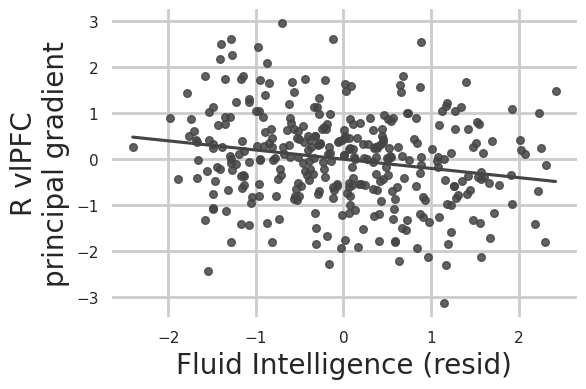

In [11]:
sns.set(font_scale=1, style='whitegrid')

f = plt.figure(figsize=[6,4])

f.add_subplot(111)
f.patch.set_facecolor('none')
sns.regplot(x='CogFluidComp_Unadj', y='G1_ROI6_Disptot', data=cog_df, ci=None, color=[.27, .27, .27], scatter_kws={'s':30, 'alpha':.85})#color=plt.cm.Dark2(5)
_=plt.ylabel('R vlPFC\nprincipal gradient', fontsize=20)
_=plt.xlabel('Fluid Intelligence (resid)', fontsize=20)
_=plt.box()
_=plt.grid(linewidth=2)

stats.spearmanr(cog_df['CogFluidComp_Unadj'], cog_df['G1_ROI6_Disptot'], nan_policy='omit')

,rho,p_adj,h
CardSort_Unadj,-0.153934,0.022806,1.0
Flanker_Unadj,-0.190241,0.002184,1.0
PMAT24_A_CR,-0.007632,1.000000,0.0
PicSeq_Unadj,-0.134523,0.066566,0.0
ListSort_Unadj,-0.027694,1.000000,0.0


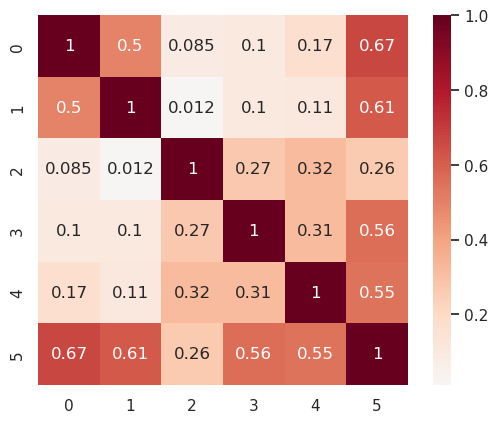

In [12]:
# test correlation between Fluid intelligence and its components
r, p = stats.spearmanr(cog_df[['CardSort_Unadj', 'Flanker_Unadj', 'PMAT24_A_CR', 'PicSeq_Unadj', 'ListSort_Unadj', 'CogFluidComp_Unadj']], nan_policy='omit')
sns.heatmap(r, square=True, annot=True, cmap='RdBu_r', center=0)

cols = ['CardSort_Unadj', 'Flanker_Unadj', 'PMAT24_A_CR', 'PicSeq_Unadj', 'ListSort_Unadj', 'CogFluidComp_Unadj', 'G1_ROI6_Disptot']
r, p = stats.spearmanr(cog_df[cols], nan_policy='omit')
r = pd.DataFrame(r, index=cols, columns=cols)
p = pd.DataFrame(p, index=cols, columns=cols)

h, pAdj, _, _ = sm.stats.multipletests(p.loc['G1_ROI6_Disptot', 'CardSort_Unadj':'ListSort_Unadj'], method='bonferroni')

pd.DataFrame(np.vstack([r.loc['G1_ROI6_Disptot', 'CardSort_Unadj':'ListSort_Unadj'], pAdj, h]).T,
             columns=['rho', 'p_adj', 'h'], index=['CardSort_Unadj', 'Flanker_Unadj', 'PMAT24_A_CR', 'PicSeq_Unadj', 'ListSort_Unadj'])

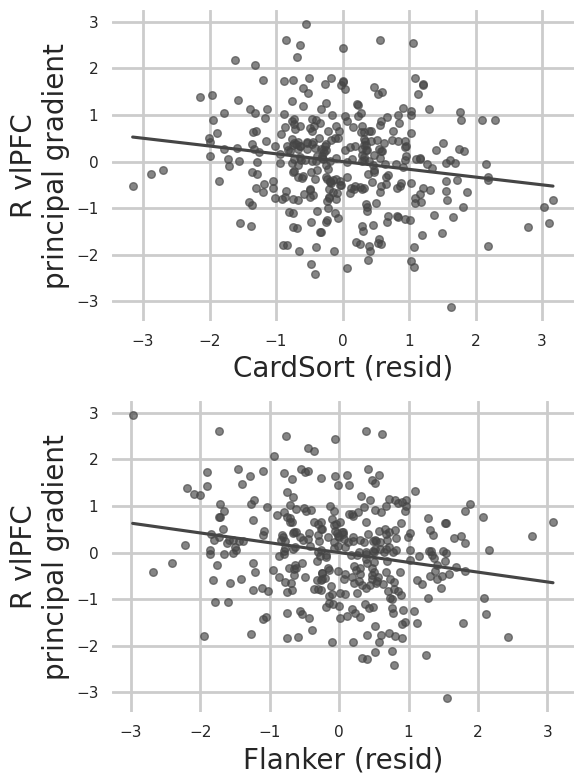

In [13]:
f = plt.figure(figsize=[6,8])
f.patch.set_facecolor('none')
sns.set(font_scale=1, style='whitegrid')

f.add_subplot(211, facecolor='none')
ax1 = sns.regplot(data=cog_df, x='CardSort_Unadj', y='G1_ROI6_Disptot', color=[.27, .27, .27], ci=None, scatter_kws={'s':30, 'alpha':.65})
_=ax1.set_ylabel('R vlPFC\nprincipal gradient', fontsize=20)
_=ax1.set_xlabel('CardSort (resid)', fontsize=20)
_=plt.box()
_=plt.grid(linewidth=2)


f.add_subplot(212, facecolor='none')
ax2 = sns.regplot(data=cog_df, x='Flanker_Unadj', y='G1_ROI6_Disptot', color=[.27, .27, .27], ci=None, scatter_kws={'s':30, 'alpha':.65})
_=ax2.set_ylabel('')
_=ax2.set_xlabel('Flanker (resid)', fontsize=20)
_=ax2.set_ylabel('R vlPFC\nprincipal gradient', fontsize=20)
_=plt.box()
_=plt.grid(linewidth=2)

plt.tight_layout()

In [1]:
''' Measure clusters' overlap with networks '''

disp_df = pd.read_csv(f"{output_dir}/{group}.gcca_dispersion.csv", header=0, usecols=["Vtx", "NW", f"DispROI_{disp_col}"])
disp_df = disp_df[disp_df[f"DispROI_{disp_col}"] > 0]

pivot = disp_df.groupby([f"DispROI_{disp_col}", "NW"]).agg("count")["Vtx"].reset_index().pivot(index=f"DispROI_{disp_col}", columns="NW", values="Vtx")
pivot.columns = np.array(nw_name)[pivot.columns.astype("int32")-1]
pivot.loc["TOT", :] = pivot.sum()
pivot.loc[:, "TOT"] = pivot.sum(axis=1)

pivot.to_csv(f"{output_dir}/{group}.gcca_disp_{disp_col}.cluster_{nw_N}NWs_overlap.csv")
pivot

NameError: name 'pd' is not defined

In [25]:
%%time

thr = 90

NWs_n_ROIs = nib.load(f'{output_dir}/{group}.iqrROIs_Schaefer2018_{lbl_N}Parcels_{nw_N}Networks.dlabel.nii')

modules_df = ct.agg_networks(NWs_n_ROIs, NWs_n_ROIs)[1][1:].reset_index()

communities = [set(modules_df.label.astype('int32')[modules_df.network==nw].values) for nw in modules_df.network.unique()]
nodes = dict( zip( range( len(modules_df.index) ), modules_df.label) )

def graph_diagnostics(subj, root_dir, communities, thr):
    M = np.genfromtxt(f'{root_dir}/{subj}/Analysis/{subj}.REST_All_fcMatrix.csv', delimiter=',')[1:, 1:]
    G = nx.from_numpy_matrix(M)
    G.threshold(thr)
    G = nx.relabel_nodes(G, nodes)
    G = nx.algorithms.full_diagnostics(G, communities)
    nx.write_gpickle(G,f'{root_dir}/{subj}/Analysis/{subj}.rfMRI_graph_{thr}.Schaefer_400parcs.gpickle')
    return subj

_ = Parallel(n_jobs=11, prefer='processes')(delayed(graph_diagnostics)(subj, root_dir, communities, thr) for subj in subj_id)


CPU times: user 1.82 s, sys: 180 ms, total: 2 s
Wall time: 2h 2min 1s


In [104]:
%%time

thr = 90
NWs_n_ROIs = nib.load(f'{output_dir}/{group}.iqrROIs_Schaefer2018_{lbl_N}Parcels_{nw_N}Networks.dlabel.nii')
modules_df = ct.agg_networks(NWs_n_ROIs, NWs_n_ROIs)[1][1:].reset_index()
communities = [set(modules_df.label.astype('int32')[modules_df.network==nw].values) for nw in modules_df.network.unique()]

def community_degree(subj, root_dir, communities):
    W = nx.read_gpickle(f'{root_dir}/{subj}/Analysis/{subj}.rfMRI_graph_{thr}.Schaefer_400parcs.gpickle')
    r = Parallel(n_jobs=8)(delayed(nx.algorithms.node_community_degree)(W, m) for m in communities[:-1])

    for i, spl in enumerate(r):
        nx.set_node_attributes(W, spl, name=f"{nw_name[i]}_degree")

    nx.write_gpickle(W, f'{root_dir}/{subj}/Analysis/{subj}.rfMRI_graph_90.Schaefer_400parcs.gpickle')


_ = Parallel(n_jobs=8)(delayed(community_degree)(subj, root_dir, communities) for subj in subj_id)


CPU times: user 113 ms, sys: 17.2 ms, total: 130 ms
Wall time: 127 ms


In [44]:
thr=90
attributes = ['strength', 'clustering', 'global_e', 'local_e', 'between_c', 'participation_c']

def get_graph(subj):
    return nx.read_gpickle(f'{root_dir}/{subj}/Analysis/{subj}.rfMRI_graph_{thr}.Schaefer_400parcs.gpickle')

individual_maps = []
for subj in subj_id:
    G = get_graph(subj)
    metrics = np.array([list(nx.get_node_attributes(G, attribute).values()) for attribute in attributes])
    
    isolates = nx.isolates(G)
    metrics[:,np.isin(G, list(isolates))] = np.nan
    individual_maps.append(metrics)
    
    
individual_maps = np.array(individual_maps)
np.save(f'{output_dir}/{group}.graph_metrics.ROIs_{lbl_N}Parc', individual_maps)

graph_dispersion_maps = stats.iqr(individual_maps, 0, rng=(25, 75), nan_policy='omit') 
graph_dispersion_df = pd.DataFrame(graph_dispersion_maps.T, columns=attributes)
graph_dispersion_df.to_csv(f'{output_dir}/{group}.graph_metrics_dispersion.IQR_Schaefer2018_{lbl_N}Parc_{nw_N}NW.csv', index=False)


joint_atlas = nib.load(f'{output_dir}/{group}.iqrROIs_Schaefer2018_{lbl_N}Parcels_{nw_N}Networks.dlabel.nii')
labels = joint_atlas.get_fdata().copy().squeeze().astype('int32')
label_idx = stats.rankdata(labels, method='dense').squeeze() -1 


scalars = np.zeros([graph_dispersion_df.shape[1], labels.size]).T

for lbl, val in graph_dispersion_df.iterrows():
    scalars[label_idx==lbl+1, :] = val.values

out = f'{output_dir}/{group}.graph_dispersion.ROIs_{lbl_N}Parc.32k_fs_LR.dscalar.nii'
ct.save_dscalar(scalars.T, joint_atlas, out, names=attributes)


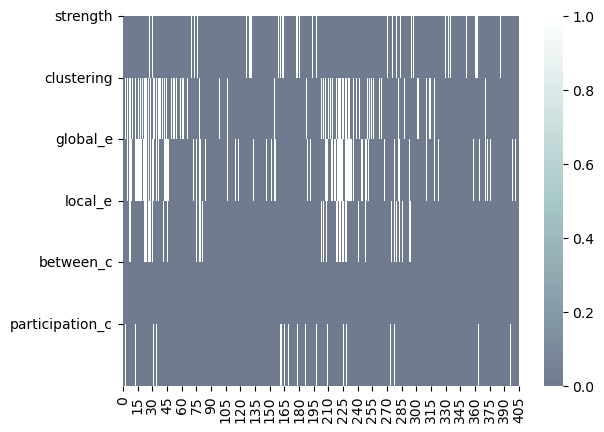

In [51]:
individual_maps.shape
_, p_norm= stats.normaltest(individual_maps, axis=0, nan_policy='omit')
sns.heatmap((abs(p_norm)>0.05), center=0, cmap='bone')
_=plt.yticks(range(6), attributes, rotation=0)

In [41]:
gcca_dispersion = np.load(f'{output_dir}/{group}.gcca_dist.ROIs_{lbl_N}Parc.npy')[:,1:]
gcca_median = np.median(np.load(f'{output_dir}/{group}.gcca.ROIs_{lbl_N}Parc.npy')[:,0,1:].squeeze(), axis=0)
graph_dispersion_df = pd.read_csv(f'{output_dir}/{group}.graph_metrics_dispersion.IQR_Schaefer2018_{lbl_N}Parc_{nw_N}NW.csv')

graph_dispersion_df['gcca_disp'] = gcca_dispersion[0]
graph_dispersion_df['gcca'] = gcca_median
graph_dispersion_df[graph_dispersion_df==0] = np.nan

for i, graph_dispersion in enumerate(graph_dispersion_df.T.iterrows()):
    if i == 6:
        break
    x = graph_dispersion_df['gcca_disp']
    y = graph_dispersion[1]
    print(graph_dispersion[0],
          f"r = {stats.spearmanr(x, y, nan_policy='omit')[0]}",
          f"p(bonferroni) = {stats.spearmanr(x, y, nan_policy='omit')[1] * 12}")

strength r = -0.159564042322663 p(bonferroni) = 0.015068960043115434
clustering r = -0.60030703286957 p(bonferroni) = 1.1516151676677921e-38
global_e r = -0.12297142641970228 p(bonferroni) = 0.1578430179075055
local_e r = -0.48376702626868134 p(bonferroni) = 2.6203218878710035e-23
between_c r = 0.2270658806618944 p(bonferroni) = 5.542843980769478e-05
participation_c r = -0.3926601211622987 p(bonferroni) = 6.770391035553099e-15


In [42]:
attributes = ['strength', 'clustering', 'global_e', 'local_e', 'between_c', 'participation_c']


gcca = np.load(f'{output_dir}/{group}.gcca.ROIs_{lbl_N}Parc.npy')[:,:,1:]
gmetrics = np.load(f'{output_dir}/{group}.graph_metrics.ROIs_{lbl_N}Parc.npy')

results = {attribute:{'r':[], 'p':[]} for attribute in attributes}

for i, parc_metrics in enumerate(gmetrics[:, :, :].T):
    for j, metric in enumerate(parc_metrics):
        r, p = stats.spearmanr(metric, gcca[:,0,i], nan_policy='omit')
        results[attributes[j]]['r'].extend(np.array([r]))
        results[attributes[j]]['p'].extend(np.array([p]))
        
for metric, dictionary in results.items():
    h, p, _, _ = sm.stats.multipletests(dictionary['p'], alpha=0.05, method='fdr_by')
    dictionary['p'] = p#h * p
    dictionary['r'] = dictionary['r']# * h
    
scalars = [results[metric][index] for metric in results.keys() for index in results[metric].keys()]
scalars = np.array(scalars)


joint_atlas = nib.load(f'{output_dir}/{group}.iqrROIs_Schaefer2018_{lbl_N}Parcels_{nw_N}Networks.dlabel.nii')
labels = joint_atlas.get_fdata().copy().squeeze().astype('int32')
label_idx = stats.rankdata(labels, method='dense').squeeze() -1 

maps_array = np.zeros([scalars.shape[0], labels.size])

for i, scalar in enumerate(scalars):
    for lbl in np.unique(label_idx):
        if lbl==0:
            continue
        maps_array[i, label_idx==lbl] = scalar[lbl-1]
    
out = f'{output_dir}/{group}.graph_metric_correlation.ROIs_{lbl_N}Parc.32k_fs_LR.dscalar.nii'
names = np.asanyarray([[f'{metric}_R', f'{metric}_pval'] for metric in results]).reshape(-1).tolist()
ct.save_dscalar(maps_array, joint_atlas, out, names=names)


In [6]:
attributes = ['strength', 'clustering', 'global_e', 'local_e', 'between_c', 'participation_c']
gcca = np.load(f'{output_dir}/{group}.gcca.ROIs_{lbl_N}Parc.npy')[:,:,1:]
gmetrics = np.load(f'{output_dir}/{group}.graph_metrics.ROIs_{lbl_N}Parc.npy')

results = {attribute:{'r':[], 'p':[]} for attribute in attributes}

for i, parc_metrics in enumerate(gmetrics[:, :, :]):
    for j, metric in enumerate(parc_metrics):
        r, p = stats.spearmanr(metric, gcca[i,0,:], nan_policy='omit')
        results[attributes[j]]['r'].extend([r])
        results[attributes[j]]['p'].extend([p])
        


In [400]:
# Load cognitive scores

tasks = ['Subject', 'CogTotalComp_Unadj', 'PicVocab_Unadj', 'ReadEng_Unadj', 'CardSort_Unadj', 'Flanker_Unadj', 'ProcSpeed_Unadj',
         'VSPLOT_CRTE', 'PMAT24_A_CR', 'PicSeq_Unadj', 'ListSort_Unadj', 'IWRD_TOT',
         'ER40_CRT', 'DDisc_AUC_200', 'DDisc_AUC_40K', 'SCPT_SPEC', 'SCPT_SEN']
cog_df = pd.read_csv(f'{root_dir}/unrestricted_fralberti_4_8_2022_8_22_23.csv',
                    usecols = tasks,
                     index_col = 'Subject').loc[subj_id,:]


covar_df = pd.merge(pd.read_csv(f'{root_dir}/unrestricted_fralberti_4_8_2022_8_22_23.csv',
                                usecols=['Subject', 'Gender'],
                                dtype={'Subject':'int32', 'Gender':'category'}),
                    pd.read_csv(f'{root_dir}/RESTRICTED_arianna_9_7_2022_8_13_11.csv',
                                usecols=['Subject', 'Age_in_Yrs', 'Handedness', 'SSAGA_Educ'],
                                dtype={'Subject':'int32', 'Age_in_Yrs':'int32', 'Handedness':'int32'}),
                    ).set_index('Subject')

covar_df = covar_df.loc[subj_id]
cog_df = cog_df.merge(covar_df, left_index=True, right_index=True)


# Correct for covariates
covars = ['C(Gender)', 'Age_in_Yrs', 'Handedness', 'SSAGA_Educ', 'CogTotalComp_Unadj']
X = ' + '.join(covars)
for col in cog_df.columns[~cog_df.columns.isin(['Gender', 'Age_in_Yrs', 'Handedness', 'SSAGA_Educ'])]:
    lm = ols(f'{col} ~ {X}', data=cog_df).fit()
    cog_df[col] = stats.zscore(lm.resid, axis=0)


gcca = np.load(f'{output_dir}/{group}.gcca.32k_fs_LR.npy')[:,0,:].astype('float64')


correlation_matrix = Parallel(n_jobs=-1)(delayed(stats.spearmanr)(cog_df[task], gradient, nan_policy='omit') for gradient in gcca.T for task in tasks[2:])


<class 'networkx.utils.decorators.argmap'> compilation 17:5: FutureWarning: modularity_matrix will return a numpy array instead of a matrix in NetworkX 3.0.


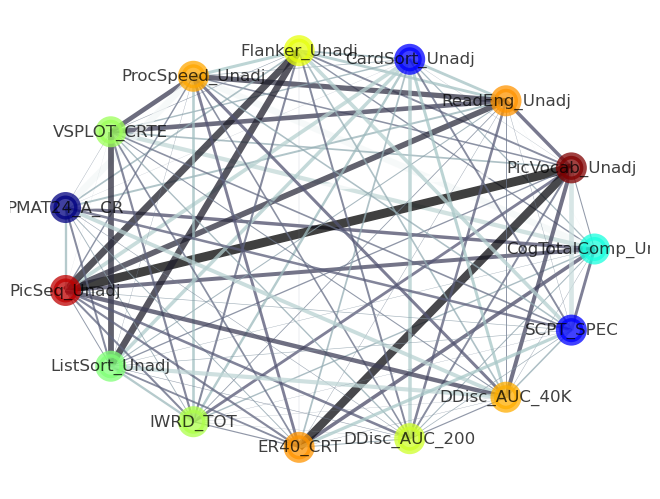

In [465]:
correlation_matrix = np.asarray(correlation_matrix)
R_matrix = correlation_matrix[:,0].reshape(len(tasks)-2, gcca.shape[1])
task_graph_W, p = stats.spearmanr(R_matrix.T)
np.fill_diagonal(task_graph_W, 0)
#task_graph_W[(task_graph_W<np.percentile(task_graph_W, [0], axis=1)) | (task_graph_W<0)] = 0
task_graph_B = task_graph_W.copy()
task_graph_B[task_graph_W > 0] = 1

G = nx.from_numpy_array(task_graph_W)
G = nx.relabel_nodes(G, dict(zip(range(len(G)), tasks[1:])))
nx.modularity_matrix(G)

modules = nx.community.louvain_communities(G, weight='weight')
modules = {node: label for label, module in enumerate(modules) for node in module}
nx.set_node_attributes(G, modules, "module")

centrality = nx.eigenvector_centrality(G, weight='weight')
nx.set_node_attributes(G, centrality, "centrality")


edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
weights = np.array(weights)

pos = nx.circular_layout(G)
colors = range(20)
options = {
    "node_color": list(nx.get_node_attributes(G, 'centrality').values()),
    "linewidths": 5,
    "alpha": .75,
    "cmap":plt.cm.jet,
    "edge_color": weights,
    "width": abs(weights)*50,
    "edge_cmap": plt.cm.bone_r,
    "with_labels": True,
    "font_color": 'k'
}
nx.draw(G, pos, **options)
plt.show()



template = nib.load(f"{output_dir}/{group}.gcca.32k_fs_LR.dscalar.nii")
ct.save_dscalar(R_matrix, template, f'{output_dir}/{group}.task_correlation.32k_fs_LR.dscalar.nii', names=tasks[2:])

In [468]:
score_correlation = cog_df[tasks[2:]].corr().values
np.fill_diagonal(score_correlation, 0)
(225-14)/2
score_correlation.shape

(15, 15)

In [473]:
score_vector = np.triu(score_correlation).reshape(-1)
R_vector = np.triu(task_graph_W).reshape(-1)
stats.spearmanr(R_vector[R_vector!=0], score_vector[score_vector!=0])

SpearmanrResult(correlation=0.04035869790586771, pvalue=0.6827086245199199)

<AxesSubplot:xlabel='network'>

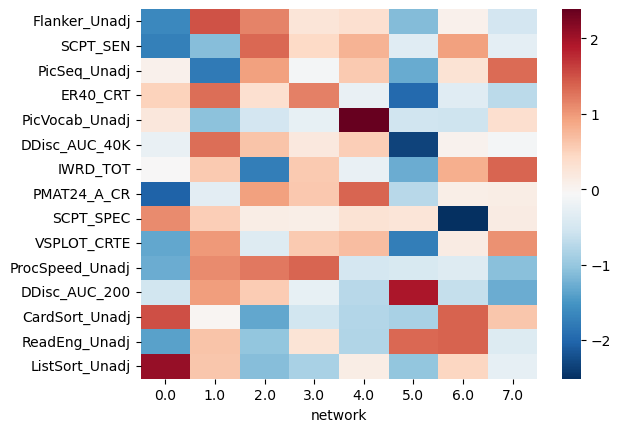

In [426]:
gccasort = np.argsort(np.median(gcca, axis=0))
tasksort = np.argsort([centrality[k] for k in centrality.keys()])
sorted_R = R_matrix[:, gccasort]
sorted_R = sorted_R[tasksort, :]


NW_correlation = ct.agg_networks(nib.load(f'{output_dir}/{group}.task_correlation.32k_fs_LR.dscalar.nii'), networks)[0]
sns.heatmap(stats.zscore(NW_correlation, axis=0).iloc[:,tasksort].T, cmap='RdBu_r')

<AxesSubplot:xlabel='network'>

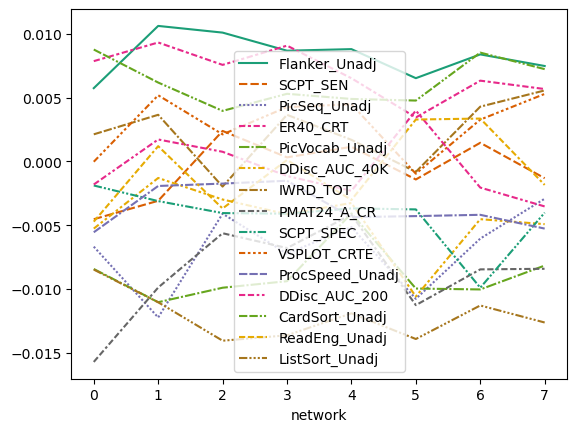

In [442]:
sns.lineplot(NW_correlation.iloc[:,tasksort], palette='Dark2')

In [209]:
''' Test Networks inter-individual variability '''

disp_df = pd.read_csv(f'{output_dir}/{group}.gcca_dispersion.csv', header = 0)

# ANOVA / KRUSKAL

results = stats.kruskal(disp_df.loc[disp_df.NW == 1, f"Disp_{disp_col}"], 
                        disp_df.loc[disp_df.NW == 2, f"Disp_{disp_col}"],
                        disp_df.loc[disp_df.NW == 3, f"Disp_{disp_col}"],
                        disp_df.loc[disp_df.NW == 4, f"Disp_{disp_col}"],
                        disp_df.loc[disp_df.NW == 5, f"Disp_{disp_col}"],
                        disp_df.loc[disp_df.NW == 6, f"Disp_{disp_col}"],
                        disp_df.loc[disp_df.NW == 7, f"Disp_{disp_col}"])


# POSTHOC
p = []
out_results = np.array(['Kruskal-Wallis', np.nan, results.statistic, results.pvalue,  np.nan])
for nw in range(1, nw_N+1):
    disp_df['NW_bool'] = disp_df.NW == nw
    
    post = stats.mannwhitneyu(disp_df.loc[disp_df.NW_bool == 1, disp], disp_df.loc[disp_df.NW_bool == 0, f"Disp_{disp_col}"],
                              use_continuity=False, alternative='greater', axis=0, method='auto')
    p.append(post.pvalue)

    mean_diff = disp_df.loc[disp_df.NW_bool == 1, f"Disp_{disp_col}"].mean() - disp_df.loc[disp_df.NW_bool == 0, f"Disp_{disp_col}"].mean()

    out_results = np.vstack([out_results, [nw_name[int(nw-1)], mean_diff, post.statistic, post.pvalue, '-']])


out_results[1:,4] = sm.stats.multipletests(p, alpha = .05, method = 'fdr_bh')[1]
resullts_df = pd.DataFrame(out_results[:,1:],
                           index = out_results[:,0],
                           columns = ['mean_diff', 'stat', 'p', 'p_adj'])
resullts_df[:] = np.round(np.float64(resullts_df), 3)
resullts_df.to_csv(f'{output_dir}/{group}.gcca_disp.{nw_N}NW_comparison.csv')
resullts_df

KeyError: 'dist'

In [ ]:
# Gradient/SD correlation vertex-level

results = pd.read_csv(f'{output_dir}/{group}.gcca_disp.{nw_N}NW_comparison.csv', index_col=0)
results = results[results.p_adj < 0.05]

variable_NWs = [nw_name.index(i) for i in results.index]

vtx_data= pd.read_csv(f'{output_dir}/{group}.gcca_dispersion.csv', index_col=0, header=0)
vtx_data[['G1', 'G2', 'G3']] = np.median(np.load(f'{output_dir}/{group}.gcca.32k_fs_LR.npy'), axis=0).T
vtx_data.to_csv(f'{output_dir}/{group}.gcca_dispersion.csv')


vtx_data = vtx_data[vtx_data.NW != 0]
print('Whole-brain:\t', stats.spearmanr(vtx_data.G1, vtx_data[f"Disp_{disp_col}"]), '\n')

for nw in variable_NWs:#np.arange(vtx_data.NW.max()):
    print(nw_name[int(nw)], ':\t', stats.spearmanr(vtx_data[vtx_data.NW==nw+1][G], vtx_data[vtx_data.NW==nw+1][disp]))
    
    lm = ols(f'{f"Disp_{disp_col}"} ~ {G}', data=vtx_data[vtx_data.NW==nw+1]).fit()
    
    print(nw_name[int(nw)], ':\tR2: ', lm.rsquared, '\n')
    


In [ ]:
''' Test association between gradient of most variable NWs and intelligence scores'''

# Load cognitive scores
cog_df = pd.read_csv(f'{output_dir}/{group}.cog_data.csv', index_col=0, header=0)

# Add gradient data to the dataframe
results = pd.read_csv(f'{output_dir}/{group}.gcca_disp.{nw_N}NW_comparison.csv', index_col=0)
results = results[results.p_adj < 0.01]
x = [nw_name.index(i)+1 for i in results.index]
variable_NWs = np.asarray(nw_name)[np.asarray(x)-1]

grads = np.load(f'{output_dir}/{group}.gcca.{lbl_N}Parc_{nw_N}NWs.npy')[:, 1:, g].copy()


cog_df[variable_NWs] = grads[:, np.asarray(x)-1]

cog_df.to_csv(f'{output_dir}/{group}.cog_data.csv')

cog_df.loc[:, cog_df.columns != 'Gender'] = stats.zscore(cog_df.loc[:, cog_df.columns != 'Gender'], axis=0, nan_policy='omit')


# Correlation
corr_test = stats.spearmanr(a=cog_df[variable_NWs],
                            b=cog_df[['CogFluidComp_Unadj', 'CogCrystalComp_Unadj', 'G']],
                            nan_policy='omit') #

# OLS F-tests
covars = ['C(Gender)', 'Age_in_Yrs', 'Handedness', 'SSAGA_Educ']
X = ' + '.join(np.hstack([variable_NWs, covars]))
F_test_p = []
F_tests = []
print(X)

for y in  ['CogFluidComp_Unadj', 'CogCrystalComp_Unadj', 'G']:
    lm = ols(f'{y} ~ {X}', data=cog_df).fit()

    A = np.identity(len(lm.params))
    A = A[1:,:]
    F = lm.f_test(A)
    
    print(y, ':\t', F)
    F_test_p.append(F.pvalue)
    [F_tests.append(mod) for mod in [lm] if F.pvalue < 0.05]


print(sm.stats.multipletests(F_test_p, alpha=.05, method='fdr_bh'))

# Post-hoc t-tests
for lm in F_tests:
    print(lm.summary())
    multicomp = sm.stats.multipletests(lm.pvalues[variable_NWs], alpha=.05, method='fdr_bh')
    print('Networks that survived FDR correction:\n\t','\n\t'.join(variable_NWs[multicomp[0]]))
    print(multicomp[1])

In [60]:
# Generate map of gradients' beta on intelligence measures

cog_df = pd.read_csv(f'{output_dir}/{group}.cog_data.csv', index_col='Subject', 
                                  usecols=['Subject', 'Age_in_Yrs', 'Handedness', 'Gender', 'SSAGA_Educ',
                                           'CogCrystalComp_Unadj', 'CogFluidComp_Unadj', 'G', 'Flanker_Unadj', 'CardSort_Unadj'])
gcca_vtx = np.load(f'{output_dir}/{group}.gcca.32k_fs_LR.npy').copy()

# Correct for covariates
covars = ['C(Gender)', 'Age_in_Yrs', 'Handedness', 'SSAGA_Educ']
X = ' + '.join(covars)
#for col in cog_df.columns[~cog_df.columns.isin(['Gender', 'Age_in_Yrs', 'Handedness', 'SSAGA_Educ'])]:
#    lm = ols(f'{col} ~ {X}', data=cog_df).fit()
#    cog_df[col] = lm.resid


adjust = True

def fun(X,y):
    xs = [f'x{i}' for i in range(X.shape[1])]
    df = pd.DataFrame(X, columns=xs)
    df['y'] = y
    df.dropna(inplace=True)
    #df = stats.zscore(df, axis=0)
    lm = ols(f"y ~ {'+'.join(xs)}", data=df).fit()
    
    
    return lm.f_pvalue

from joblib import Parallel, delayed

#F = Parallel(n_jobs=-2)(delayed(stats.spearmanr)(G1, cog_df['CogFluidComp_Unadj'].values, nan_policy='omit') for G1 in gcca_vtx[:,0,:].T)
F = Parallel(n_jobs=-2)(delayed(fun)(gradients.T, cog_df['CogFluidComp_Unadj'].values) for gradients in gcca_vtx.T)
F = np.asarray(F)
F.shape

(59412,)

In [61]:
template = nib.load(f"/home/fralberti/Data/HCP/100307/Structural/100307.gdist_prim.32k_fs_LR.dscalar.nii")
out = "/home/fralberti/Documents/BlackBox/Prj-Network_variability/Analyses-bis/338.gradients_FluidI_Fp.32k_fs_LR.dscalar.nii"
ct.save_dscalar(F.T, template, out)


In [42]:
cog_df.columns

Index(['CogFluidComp_Unadj', 'CogCrystalComp_Unadj', 'G', 'Gender',
       'Age_in_Yrs', 'Handedness', 'SSAGA_Educ'],
      dtype='object')

In [25]:
%%time
subj = 100307
M = np.genfromtxt(f'{root_dir}/Subjects/{subj}/Analysis/{subj}.REST_All_fcMatrix.csv', delimiter=',')[1:, 1:]
np.fill_diagonal(M, 0)
M[M<np.percentile(M, 99, axis=0)] = 0
G = nx.from_numpy_matrix(M)
communicability = nx.communicability(G)

joint_atlas = nib.load(f'{output_dir}/{group}.iqrROIs_Schaefer2018_{lbl_N}Parcels_{nw_N}Networks.dlabel.nii')
labels = joint_atlas.get_fdata().copy().squeeze().astype('int32')
label_idx = stats.rankdata(labels, method='dense').squeeze() -1 
network_parcels = ct.agg_networks(joint_atlas, joint_atlas)[1]
vis_nodes = network_parcels.loc['Vis'].label.values
somot_nodes = network_parcels.loc['SomMot'].label.values

tot_communicability = np.array([np.median([communicability[node][source] for source in G], axis = 0) for node in G])
#tot_communicability = (tot_communicability - tot_communicability.min()) / (tot_communicability.max() - tot_communicability.min())

vis_communicability = np.array([np.median([communicability[node][source] for source in vis_nodes], axis = 0) for node in G])
vis_communicability = (vis_communicability - vis_communicability.min()) / (vis_communicability.max() - vis_communicability.min())

somot_communicability = np.array([np.median([communicability[node][source] for source in somot_nodes], axis = 0) for node in G])
somot_communicability = (somot_communicability - somot_communicability.min()) / (somot_communicability.max() - somot_communicability.min())

sum_communicability = vis_communicability + somot_communicability

delta_communicability = (vis_communicability/tot_communicability) - (somot_communicability/tot_communicability)

prod_communicability = np.sqrt(vis_communicability * somot_communicability)
##### eq_gdist = [1-((x**2+y**2+z**2)/((x+y+z)**2)) for x,y,z in prim_gdist.T]

scalars = np.vstack([tot_communicability, vis_communicability, somot_communicability, sum_communicability, delta_communicability, prod_communicability])

maps_array = np.zeros([scalars.shape[0], labels.size])
for i, scalar in enumerate(scalars):
    for lbl in np.unique(label_idx):
        if lbl==0:
            continue
        maps_array[i, label_idx==lbl] = scalar[lbl-1]
    
out = f'/home/fralberti/Code/diffusion-models/Output/{group}.sensory_commnuicability.ROIs_{lbl_N}Parc.32k_fs_LR.dscalar.nii'
names = ['Tot', 'Vis', 'SomMot', 'Sum', 'Delta', 'Prod']
ct.save_dscalar(maps_array, joint_atlas, out, names=names)

/home/fralberti/anaconda3/lib/python3.9/site-packages/ciftools_FA/ciftools_FA.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_tbl.name[1:] = labels_tbl[1:].name.apply(lambda x: x.split('_')[2])


CPU times: user 21.8 s, sys: 75 ms, total: 21.9 s
Wall time: 21.8 s


In [12]:
vis_communicability.mean()

0.06360903308381004

In [13]:
somot_communicability.mean()

0.11199762376090328

/tmp/ipykernel_52889/1672127892.py:1: RuntimeWarning: divide by zero encountered in log
  sns.scatterplot(y=np.log(scalars[0]), x=np.log(scalars[3]), hue=scalars[1]*scalars[2])


<AxesSubplot:>

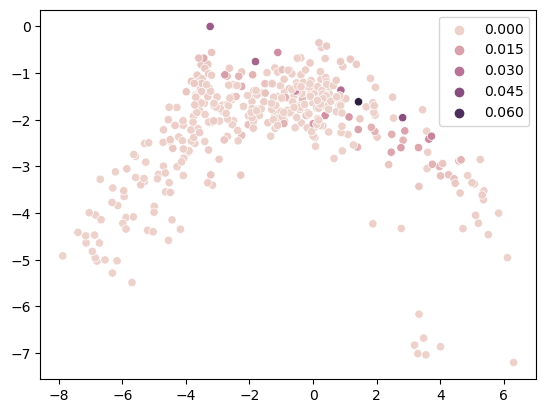

In [93]:
sns.scatterplot(y=np.log(scalars[0]), x=np.log(scalars[3]), hue=scalars[1]*scalars[2])
